# Numerical Optimization



In [1]:
library(magrittr)

Except for a few Bayesian estimators, almost all estimators in econometrics, such as OLS, MLE, 2SLS, and GMM, are optimizers of some criterion functions. Understanding how to construct an optimization problem and how to implement optimization by oneself is the key step to transform from a consumer of econometrics to a developer of econometrics. Unfortunately,  traditionally econometrics curriculum does not pay enough attention in numerical optimization. The consequence is that many students rely on the procedures that the econometric packages offer. They are unable to tailor econometric methods for their purposes; instead, they modify their data to meet standard econometric methods.



A general optimization problem is formulated as

$$
\min_{\theta \in \Theta } f(\theta) \,\, \mathrm{ s.t. }  g(\theta) = 0, h(\theta) \leq 0,
$$

where $f(\cdot)\in \mathbb{R}$ is a scalar-valued criterion function, $g(\theta) = 0$ is a vector of equality constraints,
and $h(\theta)\leq 0$ is a vector of inequality constraints.

Most established numerical optimization algorithms aim at finding a local minimum.
However, there is little guarantee that these methods should locate the global minimum when multiple local minima exist.

Optimization without the equality and/or inequality constraints is called
an *unconstrained* problem; otherwise it is called a *constrained* problem.
The constraints can be incorporated into the criterion function via Lagrangian. 
Economic students are very familiar with constrained optimization---consider utility maximization given a budget constraint.

In terms of implementation, we always face the tradeoff between convenience and efficiency.
Convenience is about the readability of the mathematical expressions and the code, 
while efficiency concerns the computing speed. We recommend that we put convenience as 
priority at the trial-and-error stage, and improves efficiency when necessary at a later stage for full-scale execution.



## Methods

There are many optimization algorithms in the field of operational research;
they are variants of a small handful of fundamental principles.

Many textbook MLE estimators are twice-differentiable but do not admit an explicit solution, for example Logit, Probit, and Tobit. The essential idea for optimizing a twice-differentiable objective function is the Newton's method. 
A necessary condition for optimization is the first-order condition
$s(\theta) = \partial f(\theta) / \partial \theta = 0$.


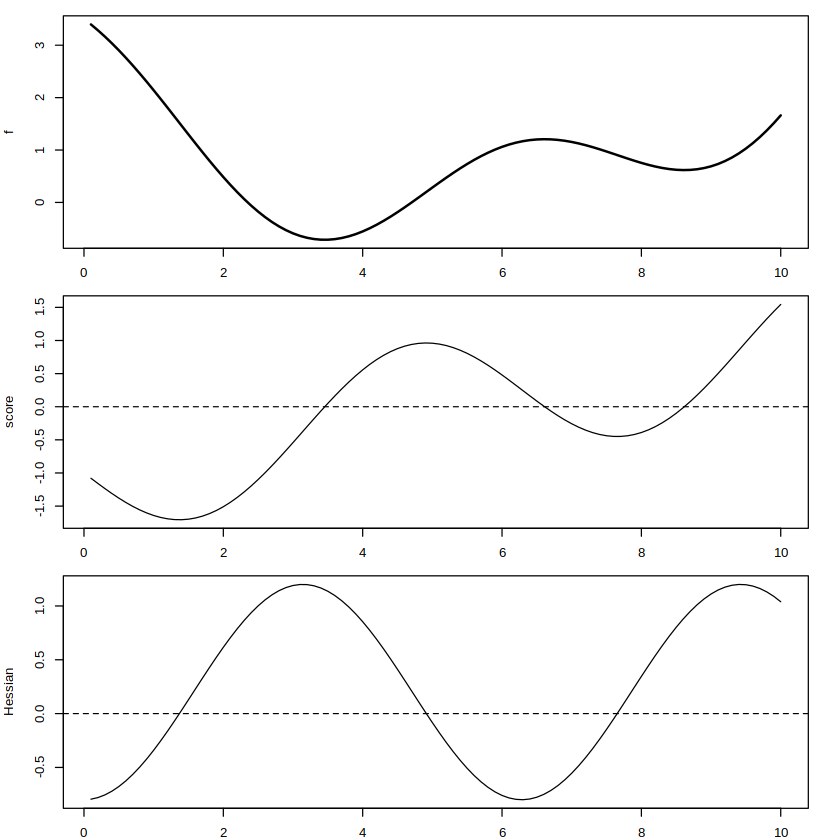

In [2]:
f <- function(x) 0.1 * (x - 5)^2 + cos(x) # criterion
s <- function(x) 0.2 * (x - 5) - sin(x) # gradient
h <- function(x) 0.2 - cos(x) # Hessian

# plot
par(mfrow = c(3, 1))
par(mar = c(2, 4, 1, 2))

x_base <- seq(0.1, 10, by = 0.1)
plot(y = f(x_base), x = x_base, type = "l", lwd = 2, ylab = "f")
plot(y = s(x_base), x = x_base, type = "l", ylab = "score")
abline(h = 0, lty = 2)
plot(y = h(x_base), x = x_base, type = "l", ylab = "Hessian")
abline(h = 0, lty = 2)


At an initial trial value $\theta_0$, if $s(\theta_0) \neq 0$, the search is updated by

$$
\theta_{t+1} = \theta_{t} -  \left( H(\theta_t)  \right)^{-1}  s(\theta_t)
$$

for the index of iteration $t=0,1,\cdots$, where
$H(\theta) = \frac{ \partial s(\theta )}{ \partial \theta}$
is the Hessian matrix. This formulate can be intuitively motivated from a Taylor expansion
at $\theta_t$ round  $\theta_{\star}$, a root of $s(\cdot)$. Because $\theta_{ \star }$  is a root,

$$
0 = s(\theta_{\star}) = s(\theta_t) + H(\theta_t) (\theta_{t+1} - \theta_t) + O( (\theta_{t+1} - \theta_t)^2 ).
$$

Ignore the high-order term and rearrange,
$\theta_{\star} = \theta_{t} -  \left( H(\theta_t)  \right)^{-1}  s(\theta_t),$ 
and we obtain the iteration formula by replacing $\theta_{\star}$ with the updated $\theta_{t+1}$. 
In other words, it is a first-order linear updating formula for a nonlinear $s(\cdot)$.  The algorithm iterates until $|\theta_{t+1} -\theta_{t}| < \epsilon$ (absolute criterion) and/or
$|\theta_{t+1} -\theta_{t}|/|\theta_{t}| < \epsilon$ (relative criterion), where
$\epsilon$ is a small positive number chosen as a tolerance level.


In [3]:
# Newton's method
Newton <- function(x) {
  x - s(x) / h(x)
} # update formula

x_init <- 6 # can experiment with various initial values

gap <- 1
epsilon <- 0.0001 # tolerance
while (gap > epsilon) {
  x_new <- Newton(x_init) %>% print()
  gap <- abs(x_init - x_new)
  x_init <- x_new
}


[1] 6.630669
[1] 6.611217
[1] 6.611302


**Newton's Method.** Newton's method seeks the solution to
$s(\theta) = 0$. Recall that the first-order condition is a necessary condition but not a sufficient
condition. We need to verify the second-order condition for each root of $s(\theta)$ to decide whether it is a minimizer, maximizer or saddle point.
If there are multiple minima, we compare the value at each to decide the
global minimum.

It is clear that Newton's method requires
computing the gradient $s(\theta)$ and the Hessian $H(\theta)$.
Newton's method numerically converges at quadratic rate.


**Quasi-Newton Method.** The most well-known quasi-Newton algorithm is  
[BFGS](http://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm).
It avoids explicit calculation of the computationally expensive Hessian matrix. Instead, starting from an initial (inverse)
Hessian, it updates the Hessian by an explicit formula motivated from the idea of quadratic approximation.

**Derivative-Free Method.** [Nelder-Mead](http://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)
is a simplex method. It searches a local minimum by reflection, expansion and contraction.



## Implementation

R's optimization infrastructure has been constantly improving.
[R Optimization Task View](http://cran.r-project.org/web/views/Optimization.html)
gives a survey of the available CRAN packages. For general-purpose nonlinear optimization, the package
[`optimx`](http://cran.r-project.org/web/packages/optimx/index.html) [@nash2014best]
effectively replaces R's default optimization commands. `optimx` provides a unified
interface for various widely-used optimization algorithms. Moreover,
it facilitates comparison among optimization algorithms. 

<!-- A relatively new package [`ROI`](https://cran.r-project.org/web/packages/ROI/index.html) [@epubwu5858] attempts to offer a consistent modeling framework to communicate with solvers. We will incorporate `ROI` in a future draft. -->



**Example**

We use `optimx` to solve pseudo Poisson maximum likelihood estimation (PPML), which is a popular estimator in international trade for cross-country bilateral trade [@silva2006log]. If $y_i$ is a continuous random variable, it obviously does not follow a Poisson
distribution whose support consists of non-negative integers. However, if the conditional mean model
$$E[y_i | x_i] = \exp( x_i' \beta),$$
is satisfied, we can still use the Poisson regression to obtain a consistent
estimator of the parameter $\beta$ even if $y_i$ does not follow a conditional
Poisson distribution.

If $Z$ follows a Poisson distribution with mean $\lambda$, the probability mass function

$$
\Pr(Z = k) = \frac{\mathrm{e}^{-\lambda} \lambda^k}{k!}, \mathrm{ for }\, \, k=0,1,2,\ldots,
$$

so that

$$
\log \Pr(Y = y | x) =  -\exp(x'\beta) + y\cdot x'\beta - \log k!
$$

Since the last term is irrelevant to the parameter, the
log-likelihood function is

$$
\ell(\beta) = \log \Pr( \mathbf{y} | \mathbf{x};\beta ) =
-\sum_{i=1}^n \exp(x_i'\beta) + \sum_{i=1}^n y_i x_i'\beta.
$$

In addition, it is easy to write the gradient

$$
s(\beta) =\frac{\partial \ell(\beta)}{\partial \beta} =
-\sum_{i=1}^n \exp(x_i'\beta)x_i + \sum_{i=1}^n y_i x_i.
$$

and verify that the Hessian

$$
H(\beta) = \frac{\partial^2 \ell(\beta)}{\partial \beta \partial \beta'} =
-\sum_{i=1}^n \exp(x_i'\beta)x_i x_i'
$$

is negative definite. Therefore, $\ell(\beta)$ is strictly concave
in $\beta$.

In operational research, the default optimization is minimization, although
 utility is maximized in economics and likelihood is maximized in statistics. 
To follow this convention in operational research, here we formulate the *negative* log-likelihood.


In [4]:
# Poisson likelihood
poisson.loglik <- function(b) {
  b <- as.matrix(b)
  lambda <- exp(X %*% b)
  ell <- -sum(-lambda + y * log(lambda))
  return(ell)
}


To implement optimization in `R`, it is recommended to write the criterion as a
function of the parameter. Data can be fed inside or outside of the function.
If the data is provided as additional arguments, these arguments must be explicit.
(In contrast, in `Matlab` the parameter must be the sole argument for the function to be
optimized, and data can only be injected through a nested function.)


In [8]:
# implement both BFGS and Nelder-Mead for comparison.

library(AER)

## prepare the data
data("RecreationDemand")
y <- RecreationDemand$trips
X <- with(RecreationDemand, cbind(1, income))

## estimation
b.init <- c(0, 1) # initial value
b.hat <- optimx::optimx(b.init, poisson.loglik,
  method = c("BFGS", "Nelder-Mead"),
  control = list(
    reltol = 1e-7,
    abstol = 1e-7
  )
)
print(b.hat)


ERROR: Error in library(AER): there is no package called ‘AER’


Given the conditional mean model, nonlinear least squares (NLS) is also consistent in theory.
NLS minimizes

$$
\sum_{i=1}^n (y_i - \exp(x_i \beta))^2
$$

A natural question is: why do we prefer PPML to NLS?  PPML's optimization for the linear index is globally convex, while NLS is not.
It implies that the numerical optimization of PPML is easier and more robust than that of NLS. I leave the derivation of the non-convexity of NLS as an exercise.


In practice no algorithm suits all problems. Simulation, where the true parameter is known,
  is helpful to check the accuracy of one's optimization routine before applying to an empirical problem,
  where the true parameter is unknown.
Contour plot is a useful tool to visualize the function surface/manifold in a low dimension.

**Example**


In [ ]:
x.grid <- seq(0, 1.8, 0.02)
x.length <- length(x.grid)
y.grid <- seq(-.5, .2, 0.01)
y.length <- length(y.grid)

z.contour <- matrix(0, nrow = x.length, ncol = y.length)

for (i in 1:x.length) {
  for (j in 1:y.length) {
    z.contour[i, j] <- poisson.loglik(c(x.grid[i], y.grid[j]))
  }
}

contour(x.grid, y.grid, z.contour, 20)


For problems that demand more accuracy,  third-party standalone solvers can be
invoked via interfaces to `R`.
For example, we can access [`NLopt`](http://ab-initio.mit.edu/wiki/index.php/NLopt_Installation)
through the packages [`nloptr`](http://cran.r-project.org/web/packages/nloptr/index.html).

`NLopt` offers an [extensive list of algorithms](http://ab-initio.mit.edu/wiki/index.php/NLopt_Algorithms#SLSQP).

**Example**

We first carry out the Nelder-Mead algorithm in NLOPT.


In [ ]:
## optimization with NLoptr

opts <- list(
  "algorithm" = "NLOPT_LN_NELDERMEAD",
  "xtol_rel" = 1.0e-7,
  maxeval = 500
)

res_NM <- nloptr::nloptr(
  x0 = b.init,
  eval_f = poisson.loglik,
  opts = opts
)
print(res_NM)

# "SLSQP" is indeed the BFGS algorithm in NLopt,
# though "BFGS" doesn't appear in the name
opts <- list("algorithm" = "NLOPT_LD_SLSQP", "xtol_rel" = 1.0e-7)


To invoke BFGS in NLOPT, we must code up the gradient $s(\beta)$,
as in the function `poisson.log.grad()` below.


In [ ]:
poisson.loglik.grad <- function(b) {
  b <- as.matrix(b)
  lambda <- exp(X %*% b)
  ell <- -colSums(-as.vector(lambda) * X + y * X)
  return(ell)
}


We compare the analytical gradient with the numerical gradient to make sure
the function is correct.


In [ ]:
# check the numerical gradient and the analytical gradient
b <- c(0, .5)
numDeriv::grad(poisson.loglik, b)
poisson.loglik.grad(b)


With the function of gradient, we are ready for BFGS.



In [ ]:
res_BFGS <- nloptr::nloptr(
  x0 = b.init,
  eval_f = poisson.loglik,
  eval_grad_f = poisson.loglik.grad,
  opts = opts
)
print(res_BFGS)


## Convex Optimization

If a function is convex in its argument, then a local minimum is a global minimum.
Convex optimization is particularly important in high-dimensional problems. The readers are
referred to @boyd2004convex for an accessible comprehensive treatment. They claim that
"convex optimization is technology; all other optimizations are arts." This is true to some extent.


In [ ]:
f1 <- function(x) x^2
f2 <- function(x) abs(x)
f3 <- function(x) (-x - 1) * (x <= -1) + (0.4 * x - .2) * (x >= .5)

par(mfrow = c(1, 3))
par(mar = c(4, 2, 1, 2))

x_base <- seq(-3, 3, by = 0.1)
plot(y = f1(x_base), x = x_base, type = "l", lwd = 2, xlab = "differentiable")
plot(y = f2(x_base), x = x_base, type = "l", lwd = 2, xlab = "non-differentiable")
plot(y = f3(x_base), x = x_base, type = "l", lwd = 2, xlab = "multiple minimizers")


**Example**

* linear regression model MLE


Normal MLE. The (negative) log-likelihood is

$$
\ell (\beta, \sigma) = \log \sigma + \frac{1}{2\sigma^2}\sum_{i=1}^n (y_i - x_i' \beta)^2
$$

This is not a convex problem, because $\log \sigma$ is concave. But if we re-parameterize the criterion function by $\gamma = 1/\sigma$ and $\alpha = \beta / \sigma$, then

$$
\ell (\alpha, \gamma) = -\log \gamma + \frac{1}{2}
\sum_{i=1}^n (\gamma y_i - x_i' \alpha)^2
$$

 in convex in $\alpha, \gamma$. Many MLE estimators in econometric textbooks are convex. 

In view of the importance of high-dimensional estimation problems, @gao2018two explore the infrastructure in R to carry out convex optimization with two econometric examples. There are several options. `CVXR` [@fu2018cvxr] is a convenient convex modeling language that supports proprietary convex solvers `CLEPX`, `MOSEK`, `Gurubi` as well as open-source solvers 	`ECOS` and `SDPT3`. While open-source solvers does not require license and can be installed in large scale in cloud computing, proprietary solvers are more faster and more reliable. `MOSEK` offers free academic license and we have had extensive experience with it. 
 [`Rmosek`](http://rmosek.r-forge.r-project.org/) offers an interface in `R` to access `Mosek` (`Rtools` is a prerequisite to install `Rmosek` in Windows.)



**Example: Relaxed empirical likelihood**



Consider a model with a "true" parameter $\beta_0$ satisfying the moment condition $\mathrm{E}\left[  h\left(Z_i, \beta_0 \right)\right] = 0_m$, where $\left\{Z_i \right\}_{i=1}^n$ is the observed data, $\beta$
is a low dimensional parameter of interest, and  $h$ is an $\mathbb{R}^{m}$-valued moment function. 
Empirical likelihood (EL) [@owen1988empirical] [@qin1994empirical] solves

$$
\max_{\beta \in \mathcal{B}, \pi \Delta_n} \; \sum_{i=1}^n \log \pi_i \;\,\, \text{s.t.} \; \sum_{i=1}^n \pi_i h \left( Z_i, \beta \right) = 0_m
$$

where $\Delta_{n} = \left\{ \pi\in\left[0,1\right]^{n}:\sum_{i=1}^{n}\pi_{i}=1 \right\}$ is the $n$-dimensional probability simplex.

To handle the high-dimensional case, i.e., $m > n$, @shi2016econometric proposes the relaxed empirical likelihood (REL),  defined as the solution to 

$$
\max_{\beta\in\mathcal{B}}\max_{\pi\in\Delta_{n}^{\lambda}\left(\beta\right)}\,\sum_{i=1}^{n}\log\pi_{i}
$$

where 

$$
\Delta_{n}^{\lambda}\left(\beta\right)=\left\{ \pi_i \in\Delta_{n}:\big|\sum_{i=1}^{n}\pi_{i}h_{ij}\left(\beta\right)\big|\leq\lambda,\:j=1,2,\cdots,m\right\}
$$

is a relaxed simplex, $\lambda\geq0$ is a tuning parameter, $h_{ij}\left(\beta\right)=h_{j}\left(Z_{i},\beta\right)$
is the $j$-th component of $h\left(Z_{i},\beta\right)$.

Similar to standard EL, REL's optimization involves an inner loop
and an outer loop. The outer loop for $\beta$ is a general low-dimensional
nonlinear optimization, which can be solved by Newton-type methods.
With the linear constraints and the logarithm objective, the inner
loop is convex in $\pi=\left(\pi_{i}\right)_{i=1}^{n}$. 
By introducing auxiliary variable, $t_i$, the logarithm objective can be formulated as a linear objective function $\sum_{i=1}^n t_i$ and $n$ exponential conic constraints, $\left(\pi_{i}, 1, t_{i}\right) \in \mathcal{K}_{\mathrm{exp}}=\left\{\left(x_{1}, x_{2}, x_{3}\right): x_{1} \geq x_{2} \exp \left(x_{3} / x_{2}\right), x_{2}>0\right\} \cup\left\{\left(x_{1}, 0, x_{3}\right): x_{1} \geq 0, x_{3} \leq 0\right\}$, $i=1,2,\cdots,n$. 




For each $\beta$, the inner problem can be then formulated as a conic programming problem,

$$
\begin{aligned}
&\max _{\pi, t} \sum_{i=1}^{n} t_{i}\\
\text { s.t. }&\left[\begin{array}{c}
1 \\
-\lambda \\
\vdots \\
-\lambda
\end{array}\right] \leq\left[\begin{array}{cccc}
1 & 1 & \cdots & 1 \\
h_{11}(\beta) & h_{21}(\beta) & \cdots & h_{n 1}(\beta) \\
\vdots & \vdots & \ddots & \vdots \\
h_{1 m}(\beta) & h_{2 m}(\beta) & \cdots & h_{n m}(\beta)
\end{array}\right]\left[\begin{array}{c}
\pi_{1} \\
\pi_{2} \\
\vdots \\
\pi_{n}
\end{array}\right] \leq\left[\begin{array}{c}
1 \\
\lambda \\
\vdots \\
\lambda
\end{array}\right]\\
&\left(\pi_{i}, 1, t_{i}\right) \in \mathcal{K}_{\mathrm{exp}}, 0 \leq \pi_{i} \leq 1, \text { for each } i=1,2, \cdots, n
\end{aligned}
$$

To understand the exponential cone, notice that 
$\left(\pi_{i}, 1, t_{i}\right) \in \mathcal{K}_{\mathrm{exp}}$ is equivalent to
$\{ \pi_i \geq \exp(t_i): \pi_i\geq 0, t_i \leq 0 \}$. It implies 
$t_i \leq \log \pi_i$. Since the problem maximizes $\sum t_i$, we must have 
$t_i = \log \pi_i$. 
The constrained optimization is readily solvable in `Rmosek` by translating the mathematical expression into computer code.


In [ ]:
innerloop <- function(b, y, X, Z, tau) {
  n <- nrow(Z)
  m <- ncol(Z)

  # Generate moment condition
  H <- MomentMatrix(y, X, Z, b)

  # Initialize the mosek problem
  Prob <- list(sense = "max")

  # Prob$dparam$intpnt_nl_tol_rel_gap <- 1e-5;
  Prob$dparam <- list(INTPNT_CO_TOL_REL_GAP = 1e-5)

  # Linear coefficients of the objective
  Prob$c <- c(rep(0, n), rep(1, n), rep(0, n))

  # Linear constraints
  H_tilde <- Matrix(rbind(rep(1, n), H), sparse = TRUE)
  A <-
    rbind(
      cbind(H_tilde, Matrix(0, m + 1, 2 * n, sparse = TRUE)),
      cbind(Matrix(0, n, 2 * n, sparse = TRUE), Diagonal(n))
    )
  Prob$A <- A
  Prob$bc <-
    rbind(c(1, rep(-tau, m), rep(1, n)), c(1, rep(tau, m), rep(1, n)))
  Prob$bx <- rbind(
    c(rep(0, n), rep(-Inf, n), rep(1, n)),
    c(rep(1, n), rep(0, n), rep(1, n))
  )

  # Exponential Cones
  NUMCONES <- n
  Prob$cones <- matrix(list(), nrow = 2, ncol = NUMCONES)
  rownames(Prob$cones) <- c("type", "sub")
  for (i in 1:n) {
    Prob$cones[, i] <- list("PEXP", c(i, 2 * n + i, n + i))
  }

  # Invoke Mosek
  mosek.out <- mosek(Prob, opts = list(verbose = 0, soldetail = 1))

  if (mosek.out$sol$itr$solsta == "OPTIMAL") {
    # Since the default of NLOPTR is to do minimization, need to set it as negative
    return(-mosek.out$sol$itr$pobjval)
  } else {
    warning("WARNING: Inner loop not optimized")
    return(Inf)
  }
}


The inner loop optimization can also be carried out by `CVXR`.
This code snippet is shorter than easier to read.


In [ ]:
innerloop.cvxr <- function(b, y = NULL, X = NULL, Z = NULL, tau = NULL) {
  n <- nrow(Z)
  m <- ncol(Z)

  H <- MomentMatrix(y, X, Z, b)

  p <- Variable(n)
  constr <- list(
    sum(p) == 1,
    p >= 0,
    p <= 1,
    H %*% p >= -tau,
    H %*% p <= tau
  )

  obj <- sum(log(p))
  obj <- Maximize(obj)

  Prob <- Problem(obj, constr)
  cvxr.out <- solve(Prob)

  if (cvxr.out$status == "optimal") {
    return(-cvxr.out$value)
  } else {
    warning("WARNING: Inner loop not optimized")
    return(Inf)
  }
}


## Future writing plan

* more convex optimization examples, for example Lasso, portfolio optimization (Shi, Su, and Xie 2020)
<!-- * Add `ROI`. -->

## Reading

* @fu2018cvxr
* @gao2018two
<!-- * @epubwu5858 -->


## References
